In [23]:
import os
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import save_image
from pathlib import Path
import os
try:
    import lpips
except:
    lpips = None

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

print("Using:", device)

Using: mps


In [24]:
class InpaintDataset(Dataset):
    def __init__(self, base_img_dir, occluded_dir, size=256):
        self.base = base_img_dir
        self.occ = occluded_dir
        self.size = size

        self.files = [
            f for f in os.listdir(occluded_dir)
            if f.endswith(".jpg") or f.endswith(".png")
            and "_mask" not in f
        ]

        self.to_tensor = T.ToTensor()
        self.resize = T.Resize((size, size))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]

        occ_path = os.path.join(self.occ, name)
        mask_path = os.path.join(self.occ, name.rsplit(".",1)[0] + "_mask.png")
        gt_path   = os.path.join(self.base, name.rsplit(".",1)[0] + ".jpg")

        occ = Image.open(occ_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        gt = Image.open(gt_path).convert("RGB")

        occ = self.resize(occ)
        mask = self.resize(mask)
        gt = self.resize(gt)

        occ_t = self.to_tensor(occ)
        gt_t  = self.to_tensor(gt)

        # mask nhị phân (vùng 1 = nơi cần inpaint)
        mask_t = (self.to_tensor(mask) > 0.5).float()[:1]

        # real edges = Canny(gt)
        gt_np = (gt_t.permute(1,2,0).numpy()*255).astype(np.uint8)
        edge = cv2.Canny(gt_np, 50, 150)
        edge = torch.from_numpy(edge/255.).float().unsqueeze(0)

        return {
            "occ": occ_t,
            "gt": gt_t,
            "mask": mask_t,
            "edge": edge,
            "name": name
        }

In [25]:
class EdgeGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [26]:
class ImageGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(5, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [27]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.net(x)

In [28]:
G1 = EdgeGenerator().to(device)
G2 = ImageGenerator().to(device)
D1 = PatchDiscriminator(2).to(device)   # edge + mask
D2 = PatchDiscriminator(4).to(device)   # rgb + mask

In [29]:
bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

opt_G1 = torch.optim.Adam(G1.parameters(), lr=1e-4)
opt_G2 = torch.optim.Adam(G2.parameters(), lr=1e-4)
opt_D1 = torch.optim.Adam(D1.parameters(), lr=1e-4)
opt_D2 = torch.optim.Adam(D2.parameters(), lr=1e-4)

In [30]:
def train_epoch(loader):
    for batch in loader:
        occ = batch["occ"].to(device)
        gt  = batch["gt"].to(device)
        mask = batch["mask"].to(device)
        edge_gt = batch["edge"].to(device)

        # -------------------------
        # 1. Train D1
        # -------------------------
        pred_edge = G1(torch.cat([occ, mask],1)).detach()

        fake_D1 = D1(torch.cat([pred_edge, mask],1))
        real_D1 = D1(torch.cat([edge_gt, mask],1))

        loss_D1 = (
            bce(fake_D1, torch.zeros_like(fake_D1)) +
            bce(real_D1, torch.ones_like(real_D1))
        ) * 0.5

        opt_D1.zero_grad()
        loss_D1.backward()
        opt_D1.step()

        # -------------------------
        # 2. Train G1
        # -------------------------
        pred_edge = G1(torch.cat([occ, mask],1))
        fake_D1 = D1(torch.cat([pred_edge, mask],1))

        loss_G1 = bce(fake_D1, torch.ones_like(fake_D1)) + l1(pred_edge, edge_gt)*50

        opt_G1.zero_grad()
        loss_G1.backward()
        opt_G1.step()

        # -------------------------
        # 3. Train D2
        # -------------------------
        edge_det = pred_edge.detach()
        pred_img = G2(torch.cat([occ, mask, edge_det],1)).detach()

        fake_D2 = D2(torch.cat([pred_img, mask],1))
        real_D2 = D2(torch.cat([gt, mask],1))

        loss_D2 = (
            bce(fake_D2, torch.zeros_like(fake_D2)) +
            bce(real_D2, torch.ones_like(real_D2))
        ) * 0.5

        opt_D2.zero_grad()
        loss_D2.backward()
        opt_D2.step()

        # -------------------------
        # 4. Train G2
        # -------------------------
        edge_det = pred_edge.detach()
        pred_img = G2(torch.cat([occ, mask, edge_det],1))

        fake_D2 = D2(torch.cat([pred_img, mask],1))

        loss_G2 = bce(fake_D2, torch.ones_like(fake_D2)) + l1(pred_img, gt)*30

        opt_G2.zero_grad()
        loss_G2.backward()
        opt_G2.step()

    return loss_G1.item(), loss_D1.item(), loss_G2.item(), loss_D2.item()

In [31]:
dataset = InpaintDataset("../data/oxford-iiit-pet/images", "../data/occluded")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for epoch in range(40):
    g1, d1, g2, d2 = train_epoch(loader)
    print(f"Epoch {epoch+1} | G1:{g1:.3f} D1:{d1:.3f} | G2:{g2:.3f} D2:{d2:.3f}")

Epoch 1 | G1:25.020 D1:0.623 | G2:5.929 D2:0.686
Epoch 2 | G1:23.554 D1:0.511 | G2:7.923 D2:0.657
Epoch 3 | G1:21.010 D1:0.495 | G2:6.525 D2:0.663
Epoch 4 | G1:16.955 D1:0.571 | G2:6.270 D2:0.673
Epoch 5 | G1:17.253 D1:0.836 | G2:5.376 D2:0.605
Epoch 6 | G1:9.210 D1:0.576 | G2:5.056 D2:0.631
Epoch 7 | G1:8.167 D1:0.535 | G2:4.204 D2:0.645
Epoch 8 | G1:13.217 D1:0.341 | G2:3.015 D2:0.564
Epoch 9 | G1:14.225 D1:0.273 | G2:3.290 D2:0.567
Epoch 10 | G1:11.753 D1:0.271 | G2:2.926 D2:0.604
Epoch 11 | G1:12.000 D1:0.290 | G2:2.604 D2:0.642
Epoch 12 | G1:6.415 D1:0.458 | G2:2.375 D2:0.659
Epoch 13 | G1:16.147 D1:0.162 | G2:3.226 D2:0.545
Epoch 14 | G1:8.651 D1:0.379 | G2:2.826 D2:0.615
Epoch 15 | G1:10.618 D1:0.252 | G2:2.045 D2:0.710
Epoch 16 | G1:5.670 D1:0.527 | G2:2.801 D2:0.540
Epoch 17 | G1:7.470 D1:0.452 | G2:2.544 D2:0.596
Epoch 18 | G1:13.336 D1:0.152 | G2:2.255 D2:0.678
Epoch 19 | G1:8.497 D1:0.370 | G2:1.976 D2:0.659
Epoch 20 | G1:12.305 D1:0.324 | G2:2.938 D2:0.603
Epoch 21 | G1:9.

In [ ]:
def infer_debug(occ_path, mask_path, save_dir="debug_out"):
    os.makedirs(save_dir, exist_ok=True)

    occ = Image.open(occ_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    occ_r = T.Resize((256,256))(occ)
    mask_r = T.Resize((256,256))(mask)

    occ_t = T.ToTensor()(occ_r).unsqueeze(0).to(device)
    mask_t = (T.ToTensor()(mask_r) > 0.5).float().unsqueeze(0).to(device)

    # Stage 1
    edges = G1(torch.cat([occ_t, mask_t],1)).detach()

    # Stage 2
    out = G2(torch.cat([occ_t, mask_t, edges],1))[0].cpu().clamp(0,1)

    # Save all
    T.ToPILImage()(occ_t[0].cpu()).save(f"{save_dir}/occ.png")
    T.ToPILImage()(mask_t[0].cpu()).save(f"{save_dir}/mask.png")
    T.ToPILImage()(edges[0].cpu()).save(f"{save_dir}/edges.png")
    T.ToPILImage()(out).save(f"{save_dir}/output.png")

    print("Saved debug images to", save_dir)

occ_img = Image.open("/Users/quan0207/School/Computer vision/DeepRestore/data/occluded/Egyptian_Mau_43.jpg").convert("RGB")
mask_img = Image.open("/Users/quan0207/School/Computer vision/DeepRestore/data/occluded/Egyptian_Mau_43_mask.png").convert("L")
result = infer_debug(occ_img, mask_img)
result.save("outputs/result.png")

In [4]:
class MiniUNet(nn.Module):
    def __init__(self, in_ch, out_ch, base=64):
        super().__init__()

        self.down1 = ConvBlock(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = ConvBlock(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.mid = ConvBlock(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.dec3 = ConvBlock(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec2 = ConvBlock(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec1 = ConvBlock(base*2, base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        m = self.mid(p3)

        u3 = self.up3(m)
        c3 = torch.cat([u3, d3], dim=1)
        d3 = self.dec3(c3)

        u2 = self.up2(d3)
        c2 = torch.cat([u2, d2], dim=1)
        d2 = self.dec2(c2)

        u1 = self.up1(d2)
        c1 = torch.cat([u1, d1], dim=1)
        d1 = self.dec1(c1)

        out = self.outc(d1)
        return torch.sigmoid(out)

In [5]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        def block(c_in, c_out, bn=True):
            layers = [nn.Conv2d(c_in, c_out, 4, stride=2, padding=1)]
            if bn: layers.append(nn.BatchNorm2d(c_out))
            layers.append(nn.LeakyReLU(0.2, True))
            return layers

        self.model = nn.Sequential(
            *block(in_ch, 64, bn=False),
            *block(64, 128),
            *block(128, 256),
            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
def gan_d_loss(real, fake):
    return (torch.mean((real - 1)**2) + torch.mean(fake**2)) / 2

def gan_g_loss(fake):
    return torch.mean((fake - 1)**2)

l1 = nn.L1Loss()

lpips_fn = lpips.LPIPS(net='alex').to(device) if lpips else None

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/quan0207/miniforge3/envs/deeprestore/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/Users/quan0207/miniforge3/envs/deeprestore/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/quan0207/miniforge3/envs/deeprestore/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Stage 1: Edge Generator
G1 = MiniUNet(in_ch=4, out_ch=1).to(device)

# Stage 2: Inpaint Generator
G2 = MiniUNet(in_ch=5, out_ch=3).to(device)

# Discriminators
D1 = PatchDiscriminator(in_ch=1).to(device)   # for edges
D2 = PatchDiscriminator(in_ch=3).to(device)   # for images

opt_G1 = torch.optim.Adam(G1.parameters(), lr=2e-4)
opt_G2 = torch.optim.Adam(G2.parameters(), lr=2e-4)
opt_D1 = torch.optim.Adam(D1.parameters(), lr=2e-4)
opt_D2 = torch.optim.Adam(D2.parameters(), lr=2e-4)

In [8]:
data_root = "../data"

img_dir = os.path.join(data_root, "oxford-iiit-pet/images")
occ_dir = os.path.join(data_root, "occluded")

print("img_dir exists:", os.path.exists(img_dir))
print("occ_dir exists:", os.path.exists(occ_dir))

dataset = InpaintDataset(
    base_img_dir=img_dir,     # đúng tên argument
    occluded_dir=occ_dir,     # đúng tên argument
    size=256
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)
EPOCHS = 40

img_dir exists: True
occ_dir exists: True


In [10]:
for epoch in range(EPOCHS):
    for batch in loader:
        occ = batch["occ"].to(device)
        gt  = batch["gt"].to(device)
        mask = batch["mask"].to(device)
        gt_edges = batch["edges"].to(device)

        # -------------------------------
        # Stage 1: Edge Generator Training
        # -------------------------------

        inp1 = torch.cat([occ, mask], dim=1)       # [occ RGB + mask]
        pred_edges = G1(inp1)

        # Discriminator D1
        fake_D1 = D1(pred_edges.detach())
        real_D1 = D1(gt_edges)
        loss_D1 = gan_d_loss(real_D1, fake_D1)

        opt_D1.zero_grad()
        loss_D1.backward()
        opt_D1.step()

        # G1 loss
        fake_D1 = D1(pred_edges)
        loss_G1 = gan_g_loss(fake_D1) + l1(pred_edges, gt_edges)*50

        opt_G1.zero_grad()
        loss_G1.backward()
        opt_G1.step()

        # -------------------------------
        # Stage 2: Image Inpainting
        # -------------------------------

        edges_no_grad = pred_edges.detach()  # detach graph
        inp2 = torch.cat([occ, mask, edges_no_grad], dim=1)
        pred_img = G2(inp2)

        # D2
        fake_D2 = D2(pred_img.detach())
        real_D2 = D2(gt)
        loss_D2 = gan_d_loss(real_D2, fake_D2)

        opt_D2.zero_grad()
        loss_D2.backward()
        opt_D2.step()

        # G2 loss
        fake_D2 = D2(pred_img)
        loss_img = l1(pred_img, gt) * 30 + gan_g_loss(fake_D2)

        if lpips_fn:
            loss_img += lpips_fn(pred_img*2-1, gt*2-1).mean() * 2

        opt_G2.zero_grad()
        loss_img.backward()
        opt_G2.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"G1:{loss_G1.item():.3f} D1:{loss_D1.item():.3f} | "
          f"G2:{loss_img.item():.3f} D2:{loss_D2.item():.3f}")

Epoch 1/40 | G1:17.026 D1:0.139 | G2:9.448 D2:0.038
Epoch 2/40 | G1:7.768 D1:0.039 | G2:7.086 D2:0.156
Epoch 3/40 | G1:11.843 D1:0.032 | G2:5.053 D2:0.127
Epoch 4/40 | G1:10.886 D1:0.017 | G2:5.888 D2:0.027
Epoch 5/40 | G1:6.909 D1:0.010 | G2:3.669 D2:0.157
Epoch 6/40 | G1:5.953 D1:0.010 | G2:3.461 D2:0.133
Epoch 7/40 | G1:5.782 D1:0.008 | G2:3.796 D2:0.090
Epoch 8/40 | G1:9.477 D1:0.006 | G2:4.866 D2:0.225
Epoch 9/40 | G1:3.870 D1:0.018 | G2:2.761 D2:0.267
Epoch 10/40 | G1:10.714 D1:0.008 | G2:3.184 D2:0.269
Epoch 11/40 | G1:11.883 D1:0.006 | G2:2.605 D2:0.267
Epoch 12/40 | G1:9.950 D1:0.004 | G2:3.720 D2:0.282
Epoch 13/40 | G1:11.015 D1:0.004 | G2:3.393 D2:0.210
Epoch 14/40 | G1:8.227 D1:0.004 | G2:2.486 D2:0.212
Epoch 15/40 | G1:11.459 D1:0.005 | G2:2.665 D2:0.175
Epoch 16/40 | G1:12.291 D1:0.004 | G2:3.802 D2:0.099
Epoch 17/40 | G1:14.917 D1:0.006 | G2:3.312 D2:0.116
Epoch 18/40 | G1:14.964 D1:0.006 | G2:4.112 D2:0.046
Epoch 19/40 | G1:14.765 D1:0.004 | G2:3.168 D2:0.174
Epoch 20/4

In [12]:
def infer(occ_img, mask_img):
    occ = T.Resize((256,256))(occ_img)
    mask = T.Resize((256,256))(mask_img)

    occ_t = T.ToTensor()(occ).unsqueeze(0).to(device)
    mask_t = (T.ToTensor()(mask) > 0.5).float().unsqueeze(0).to(device)

    inp1 = torch.cat([occ_t, mask_t], 1)
    edges = G1(inp1)

    inp2 = torch.cat([occ_t, mask_t, edges], 1)
    out = G2(inp2)[0]

    return T.ToPILImage()(out.cpu().clamp(0,1))

occ_img = Image.open("/Users/quan0207/School/Computer vision/DeepRestore/data/occluded/Egyptian_Mau_43.jpg").convert("RGB")
mask_img = Image.open("/Users/quan0207/School/Computer vision/DeepRestore/data/occluded/Egyptian_Mau_43_mask.png").convert("L")
result = infer(occ_img, mask_img)
result.save("outputs/result.png")

Saved to: outputs/Egyptian_Mau_43_inpaint.png


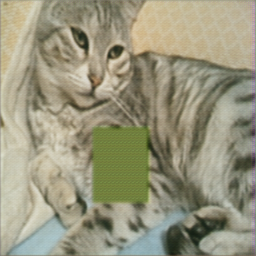

In [13]:
def infer_and_save(occ_path, mask_path, out_path):
    occ = Image.open(occ_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    result = infer(occ, mask)
    result.save(out_path)

    print("Saved to:", out_path)
    return result

# Example usage:
infer_and_save(
    "../data/occluded/Egyptian_Mau_43.jpg",
    "../data/occluded/Egyptian_Mau_43_mask.png",
    "outputs/Egyptian_Mau_43_inpaint.png"
)